In [414]:
# Current test dataset scrape and load works, but not to build a sufficient model 

    # select and narrow down input features for model
        # features from live dataset:
            # [1] order size
            # [2] time (may not be used or extremely difficult to factor in)
        # potential calcuated features to be added alongside input:
            # [3] order position from execution point/"spread"
            # [4] order size delta from last update
        # potential features from additional API input:    
            # [5] extract candlestick data for the last hour or 15 minutes
                # calc overall slope/trend for that hour
                # factor in support and resistance points for candles with long wicks for that hour
                    # establish those zones as potential breakpoints
                    # as current price approaches those breakpoints, weight size more in model     
                # Use TA-lib wrapper to auto establish support and resistance zones for the 15 minute/1 hour chart
                    # (https://github.com/mrjbq7/ta-lib)
            # [6] severe hashrate changes  ("https://blockchain.info/q/hashrate")
                # if hashrate for total network has sharp change down, buy walls likely to encouter less resistance
                # assumed negative correlation
                # put in range to prevent small changes from overinfluencing model
            # [7] severe unconfirmed tx ("https://blockchain.info/q/unconfirmedcount")
                # similar to [6], except that with sharp increase up, sell walls likely to encouter less resistance
                # assumed positive correlation
                # put in range to prevent small changes from overinfluencing model

        # Calculate orderbook states from L2 updates
            # pick interval between applying l2update to last updated snapshot
            # 5 minutes, 15 minutes
            
    # Model selection
        # Supervised = feature[x1,x2,x3....], target[y]
            # features[x] --> variables with predictive power

            # Supervised (output value or label is known)
                # 1D CNN/2D (position and size of orderbook)
                # LSTM/GRU
                    # regression vs classification example difference : 
                        #predicting price as value over time vs. price direction over time
                         
        # Reinforcement learning ---> categorial cross entropy of likelyhood that this "wall" is STRONG or WEAK
            # i.e. supported or not suppported; don't know exactly outcome [y]
                # but still able to predict an assumed categorical class class []
                    
###########################
        
        # UPDATE CYCLE: EVERY 15 MINUTES 
            # [position,size,size delta]
                #features= [position,size,size delta]
                    # algorithm sets y variable labels based upon prexisting historical data 
                    # logistic classification: [strong, weak, fake, real]
                        # "known relationship" -> identify class that the data belongs 
                        # Technically pseudo-labeling/semi-supervised learning approach ##
            # set [y] variable to true or scale from 0-1 for all orders near key S/R areas for past 15 min
                # TA-lib library + numpy + pandas = should be able to do this
         
        # pull websocket l2/snapshot data + candlesticks for past 15 minutes
            # apply scale or label to l2 
                # scale updated upon position change or next l2 update (15 minute sync)
                
                
###########################

###Model design
        # model = Sequential()
    ###INPUT LAYER
                                    ## [samples,timesteps,features] ##
                                    # samples = data rows
                                    # timesteps
                                        # How long in time each sample is; 
                                            # if feeding in 15 minutes, then 15 ticks?
                                            # 5 minutes may be more practical
                                    # features = features
            
        # model.add(LSTM(2))
        # model.add(Dense(1))
    ###OUTPUT LAYER
        # Softmax activation 
        # One node per class value if one hot encodedinput         
            
            

In [464]:
# Imports
import pandas as pd
import numpy as np
import json
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

# Charting-specific imports
import matplotlib.finance
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc
from matplotlib.finance import volume_overlay,volume_overlay2
from matplotlib.dates import  DateFormatter, epoch2num
# https://matplotlib.org/api/finance_api.html#module-matplotlib.finance

import requests
import gdax

# Pymongo import for connection to local client DB
import pymongo
from pymongo import MongoClient

# Preprocessing Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,OneHotEncoder
from keras.utils import to_categorical 

# ML Imports 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras import backend as K

#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        #inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        #device_count = {'CPU' : 1, 'GPU' : 1})
#session = tf.Session(config=config)
#K.set_session(session)


# Import to check check for GPU availability for tensorflow backend
from tensorflow.python.client import device_lib


In [416]:
# Historic rates 15 minute basis example
# Build 15 minute chart from this data - time series olhc&vol data

public_client = gdax.PublicClient()
chart_1hr =public_client.get_product_historic_rates('BTC-USD', granularity=3600) 
chart_15m =public_client.get_product_historic_rates('BTC-USD', granularity=900)
    # 900 seconds = 15 minutes,  # 3600 seconds = 1 hour
    # Potentially compare to 6h/1d as overall reference for uptrend/downtrend short term
    # Structure of response: 
        # [ time, low, high, open, close, volume ]
        
    # Pass start and end date/time as unix timestamp for past hour
    # Dates in unix/ISO_8601 format: https://en.wikipedia.org/wiki/ISO_8601

In [417]:
# Convert chart data response into dataframes
chart_1hr_df =pd.DataFrame.from_records(chart_1hr,columns=["time","low", "high","open" ,  "close", "volume"])
chart_15m_df =pd.DataFrame.from_records(chart_15m,columns=["time","low", "high","open" ,  "close", "volume"])

In [418]:
# Current hashrate and unconfirmed TX from blockchain.info
    # limit quests to a maximum of 1 every 10 seconds.
# Estimated hashrate in gigahash
response = requests.get("https://blockchain.info/q/hashrate")
print(response.json())
# Number of pending unconfirmed transactions
response2 = requests.get("https://blockchain.info/q/unconfirmedcount")
print(response2.json())

30345703041
2429


In [419]:
# start/end time from request log
request_log_df= pd.read_csv("test_data/request_log.csv")
print(request_log_df.head())

      Unnamed: 0                       iso         epoch
0    request end  2018-04-17T01:05:03.469Z  1.523927e+09
1  request start  2018-04-17T00:55:03.354Z  1.523927e+09


In [420]:
chart_15m_df.head()

,time,low,high,open,close,volume
0,1524087480,8187.48,8187.48,8187.48,8187.48,0.269797
1,1524087420,8187.48,8187.49,8187.49,8187.49,9.063333
2,1524087360,8187.48,8187.49,8187.49,8187.48,7.419944
3,1524087300,8185.99,8187.49,8185.99,8187.48,1.762627
4,1524087240,8184.99,8186.00,8184.99,8186.00,8.712934


In [421]:
chart_15m_df = chart_15m_df[["time","open","high","low","close","volume"]]
chart_15m_df.head()

,time,open,high,low,close,volume
0,1524087480,8187.48,8187.48,8187.48,8187.48,0.269797
1,1524087420,8187.49,8187.49,8187.48,8187.49,9.063333
2,1524087360,8187.49,8187.49,8187.48,8187.48,7.419944
3,1524087300,8185.99,8187.49,8185.99,8187.48,1.762627
4,1524087240,8184.99,8186.00,8184.99,8186.00,8.712934


In [423]:
chart_15m_df['time'] =pd.to_datetime(chart_15m_df['time'],unit='s')
chart_15m_df.head()

,time,open,high,low,close,volume
0,2018-04-18 21:38:00,8187.48,8187.48,8187.48,8187.48,0.269797
1,2018-04-18 21:37:00,8187.49,8187.49,8187.48,8187.49,9.063333
2,2018-04-18 21:36:00,8187.49,8187.49,8187.48,8187.48,7.419944
3,2018-04-18 21:35:00,8185.99,8187.49,8185.99,8187.48,1.762627
4,2018-04-18 21:34:00,8184.99,8186.00,8184.99,8186.00,8.712934


In [ ]:
# Auto support/resistance adapted into function
    # Source: Adapted from https://github.com/nakulnayyar/SupResGenerator
from pandas_datareader import data, wb
from sklearn.cluster import MeanShift, estimate_bandwidth

def autoSR(dataframe):
    data = chart_15m_df.as_matrix(columns=['close'])
    data2 = data[:len(data)*1]
    bandwidth = estimate_bandwidth(data2, quantile=0.1, n_samples=100)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data2)
    ml_results = []
    for k in range(len(np.unique(ms.labels_))):
            my_members = ms.labels_ == k
            values = data[my_members, 0]    
            ml_results.append(min(values))
            ml_results.append(max(values))
    return ml_results

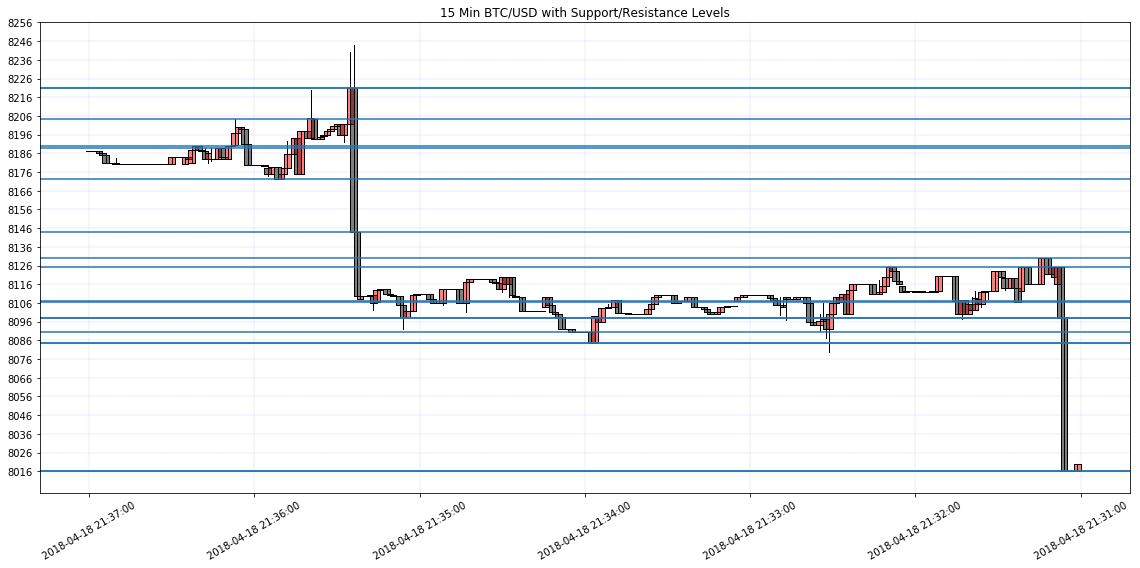

In [503]:
# Generate chart of past 15 minutes with autogenerated support and resistance levels:
fig, ax = plt.subplots(figsize=(16, 8)
                     )
candlestick2_ohlc(ax,chart_15m_df['open'],chart_15m_df['high'],chart_15m_df['low'],chart_15m_df['close'],width=2,\
                  colorup='k',colordown='r',alpha=.5)
ax.set_xticklabels(chart_15m_df['time'] ,rotation=30)
plt.yticks(np.arange(min(chart_15m_df['low']), max(chart_15m_df['high'])+20, 10))
#ax.minorticks_on()
ax.set_axisbelow(True)
ax.grid(which='major', linestyle='--', linewidth='0.1', color='b')
matplotlib.pyplot.title("15 Min BTC/USD with Support/Resistance Levels")
#volume_overlay2(chart_15m_df['close'],chart_15m_df['volume'],width=1,colorup='k',colordown='r',alpha=1)
autoSR(chart_15m_df)
for k in ml_results:
    plt.axhline(y=k)
plt.tight_layout()
plt.show()

In [502]:
print("Auto generated support and resistance levels for past 15 minutes:")
print(ml_results)

Auto generated support and resistance levels for past 15 minutes:
[8106.91, 8125.1, 8097.99, 8106.41, 8172.13, 8188.95, 8189.95, 8204.18, 8090.62, 8097.83, 8016.01, 8016.01, 8221.02, 8221.02, 8129.99, 8143.93, 8084.39, 8084.39]
